# Covid-19 Monitoring Notebook 
The Johns Hopkins Center for Systems Science and Engineering (CSSE) operates a [dashboard](https://systems.jhu.edu/research/public-health/ncov/) on the Web to follow the covid-19 cases and deaths all over the world. The data is collected on a daily basis from different sources and has been made available on [Github](https://github.com/CSSEGISandData/COVID-19). This is a selection for some European countries. The observed cases are shown for each country and then merged together for comparison.

[Italy](#Italy)  
[Germany](#Germany)  
[France](#France)  
[Spain](#Spain)  
[Comparisons](#Comparisons)  
[Summary](#Summary)

***
## Definitions
We follow the definitions for measures as given in the book by Bonita et al., [Basic Epidemiology, 2nd ed.](https://apps.who.int/iris/handle/10665/43541) available in different languages from the World Health Organization website. 

***Confirmed Case*** according to the European Centre for Disease Prevention and Control, a person with laboratory confirmation of virus causing COVID-19 infection, irrespective of clinical signs and symptoms.

***Cumulative Incidence*** is the number of new cases of the disease during a specified period of time in a specific healthy population. It represents the risk of becoming ill. In this notebook the period of time considered is from the onset of the disease  up to the last update report and the population at risk is the entire population of a country. The cumulative incidence is computed as the ratio between the cumulative confirmed infections and the country's population, assuming that a vast majority is still healthy, per 100.000 people (see Bonita et al., p.21). If, at any given time point t, C(t) denotes the cumulative confirmed infections and P(t) denotes the population at risk, that we assume for the time being to be the entire population of a country, the cumulative incidence CI(t) is

$$CI(t) = \frac{C(t)}{P(t)}\times100.000$$

***Case Fatality*** represents the ratio between the number of people who have died from the infection and the number of people who have been confirmed to be infected, expressed as a percentage. In this notebook it is computed as the ratio between the cumulative deaths and the cumulative confirmed infections (see Bonita et al., p.22). If, at any given time point t, C(t) denotes the cumulative confirmed infections, as before, and D(t) denotes the cumulative number of deaths, the case fatality CF(t) is 

$$CF(t) = \frac{D(t)}{C(t)}\times100$$

This is a crude estimation of the case fatality that does not take into account the time delay that occurs between the confirmation of an infection and its outcome, being a recovery or a death.  

***Doubling Time*** is the time it takes for a parameter to double in value. In this notebook it is computed for the cumulative confirmed infections by finding the day, before the last one, in which the value was a half. The longer time it takes for the number of infections to double, and the higher is the value of the doubling time, the better.  

***Basic Reproduction Number $R_0$*** is the expected number of secondary cases generated by one infected individual in a population where all individuals are susceptibles, i.e. no one is immunized because of recovery or vaccination. According to the [Susceptible-Infectious-Recovered](https://en.wikipedia.org/wiki/Compartmental_models_in_epidemiology) (SIR) deterministic model, it is possible to predict the number of infections $I(t)$ over the time $t$, at the early stage of an outbreak, using the equation  

$$I(t) = I_0\exp^{\frac{R_0 - 1}{d} t}$$

where $d$ represents the average duration of the infection for an individual. From this equation it can be seen that, if $R_0 > 1$ there will be an epidemic outbreak. A rough estimation of $R_0$ can be computed using the doubling time $\Delta t_2$ such that  


$$\frac{I(t)}{I_0} = \exp^{\frac{R_0 - 1}{d} \Delta t_2} = 2$$


taking the logarithm of both sides we have

$$\frac{R_0 - 1}{d} \Delta t_2 = log(2)$$


and finally 

$$ R_0 = log(2) \frac{d}{\Delta t_2} + 1$$

Assuming a duration of the infection of, e.g. $d = 30$ days from the onset, few days before the symptoms appear till complete recovery, and computing the doubling time from the data of confirmed infections, as soon as they are available, we can get a rough estimation of $R_0$. The basic reproduction number $R_0$ can be used to estimate if and how quickly an infection can spread in a population. Since in the SIR model $R_0$ depends on the rate of contacts that people have, it is clear that social distance is an important action to prevent the spread of the infection, if enacted at its onset. One limitation of $R_0$, computed from the confirmed infection, is that it can underestimate its real value since the majority of the cases are individuals who had only mild or even no symptoms at all.


## References

* [Report of the WHO-China Joint Mission on Coronavirus Disease 2019 (COVID-19)](https://www.who.int/docs/default-source/coronaviruse/who-china-joint-mission-on-covid-19-final-report.pdf)
* [Riou et al. - Adjusted age-specific case fatality ratio during the COVID-19 epidemic in Hubei, China, January and February 2020](https://www.medrxiv.org/content/10.1101/2020.03.04.20031104v1)
* [Russell et al. - Using a delay-adjusted case fatality ratio to estimate under-reporting](https://cmmid.github.io/topics/covid19/severity/global_cfr_estimates.html) 
* [Verity et al. - Estimates of severity of COVID-19 disease](https://www.medrxiv.org/content/10.1101/2020.03.09.20033357v1)
* [Wu et al. - Nowcasting and forecasting the potential domestic and international spread of the 2019-nCoV outbreak originating in Wuhan, China: a modelling study](https://www.thelancet.com/journals/lancet/article/PIIS0140-6736(20);30260-9/fulltext)
* [Liu et al. - Measurability of the epidemic reproduction number in data-driven contact networks](https://www.ncbi.nlm.nih.gov/pubmed/30463945)

## Software 
This notebook uses python as programming language, and some libraries, pandas for data handling and matplotlib for data visualization. The covid-19 data is handled as pandas time series and is visualized as simple line plot with the dates as x dimension and the observation as y dimension. Bar charts cannot use directly pandas' time series objects so two separated arrays are created from the time series to be used as input for bar charts, days and observations. The solution used may change if better libraries are discovered.

<a href="https://colab.research.google.com/github/luigiselmi/datascience/blob/master/python/covid19-monitoring-notebook.ipynb" target="_blank"><img align="left" src="https://colab.research.google.com/assets/colab-badge.svg" width="117" height="20"></a>


In [1]:
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
import matplotlib.dates as mdates
from datetime import datetime
import seaborn as sns; sns.set()
import warnings
#warnings.filterwarnings('ignore')
from platform import python_version
print("python version: %s"%python_version())
print("numpy version: %s"%np.__version__)
print("pandas version: %s"%pd.__version__)
print("matplotlib version: %s"%mpl.__version__)

python version: 3.7.4
numpy version: 1.16.5
pandas version: 0.25.1
matplotlib version: 3.3.1


### Functions
A collection of functions that are not directly available in the python libraries.

In [2]:
def doubling_time(timeseries):
    """Computes the number of days for the values to double since the last day"""
    dt = pd.Series(index = timeseries.index)
    for last_day in timeseries.sort_index(ascending=False).index.strftime('%Y-%m-%d'): 
        for d in timeseries.sort_index(ascending=False).index: # sorts the dates in descending order
            if timeseries[last_day] - timeseries[d] * 2 >= 0:
                dt[last_day] = (pd.to_datetime(last_day) - d).days 
                break
    return dt.fillna(0).astype('int32')

### Data Structures

In [3]:
countries = ['Italy', 'Germany', 'France', 'Spain']
summary = pd.DataFrame(columns = ['Confirmed Infections', 'Doubling Time', 'Incidence', 'Deaths', 'Case Fatality'], 
                       index = countries)

***
## Data sources

### Johns Hopkins CSSE - Covid-19 Epidemiological data 

In [4]:
#url_confirmed = "https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_19-covid-Confirmed.csv"
url_confirmed = "https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_confirmed_global.csv"
confirmed_dataset = pd.read_csv(url_confirmed) 
#url_deaths = "https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_19-covid-Deaths.csv"
url_deaths = "https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_deaths_global.csv"
deaths_dataset = pd.read_csv(url_deaths)
# creates an index of dates
start_date_index = 43 # starts from March 1st
end_date_index = len(confirmed_dataset.columns) 
start_day = pd.to_datetime(confirmed_dataset.columns[start_date_index]).strftime('%Y-%m-%d')
end_day = pd.to_datetime(confirmed_dataset.columns[end_date_index - 1]).strftime('%Y-%m-%d')
date_index = pd.date_range(start_day, end_day)
week_index = pd.date_range(start_day, end_day, freq='W')
date_index_array = [date.strftime('%Y-%m-%d') for date in date_index] # dates array used for plotting

### Eurostat population data

In [5]:
url_population = "https://raw.githubusercontent.com/luigiselmi/datascience/master/python/covid19/data/eurostat_population_by_age_2019.csv"
population = pd.read_csv(url_population)

### Eurostat health care facilities
Number of available beds (2017)

In [6]:
url_beds = "https://raw.githubusercontent.com/luigiselmi/datascience/master/python/covid19/data/eurostat_hlth_rs_bds.csv"
beds = pd.read_csv(url_beds)

***
## Italy

In [7]:
population_it = population[population['country_code'] == 'IT']['total'].values[0]
print("Italy's population (2019) = %d"%population_it)

Italy's population (2019) = 60359546


In [8]:
beds_it = beds[beds['country_code'] == 'IT']['2017'].values[0]
print("Italy's public and private health care facilities, available beds in 2017 = %d"%beds_it)

Italy's public and private health care facilities, available beds in 2017 = 192548


In [9]:
people_per_bed_it =  population_it / beds_it 
print("Number of persons per bed = %.0f"%people_per_bed_it)

Number of persons per bed = 313


### Cumulative confirmed infections
The number of infected individuals each day is the sum of all the confirmed infected individuals from the beginning up to that day.

In [10]:
confirmed_dataset_it = confirmed_dataset[confirmed_dataset['Country/Region'] == 'Italy']
confirmed_dataset_values_it = [confirmed for confirmed in confirmed_dataset_it.values[0][start_date_index:]] 
confirmed_infections_it = pd.Series(confirmed_dataset_values_it, index=date_index)
confirmed_infections_it['2020-10-01':]

2020-10-01    317409
2020-10-02    319908
2020-10-03    322751
2020-10-04    325329
2020-10-05    327586
2020-10-06    330263
2020-10-07    333940
2020-10-08    338398
2020-10-09    343770
2020-10-10    349494
2020-10-11    354950
Freq: D, dtype: int64

### Confirmed infections per day
The confirmed infections per day are computed from the cumulative confirmed infections by computing the difference between two consecutive days.

In [11]:
confirmed_per_day_array_it = [confirmed_infections_it[d++1] - confirmed_infections_it[d] for d in range(date_index.size - 1)]
confirmed_per_day_it = pd.Series(confirmed_per_day_array_it, index=date_index[1:])
confirmed_per_day_it['2020-10-01':]

2020-10-01    2548
2020-10-02    2499
2020-10-03    2843
2020-10-04    2578
2020-10-05    2257
2020-10-06    2677
2020-10-07    3677
2020-10-08    4458
2020-10-09    5372
2020-10-10    5724
2020-10-11    5456
Freq: D, dtype: int64

<BarContainer object of 224 artists>

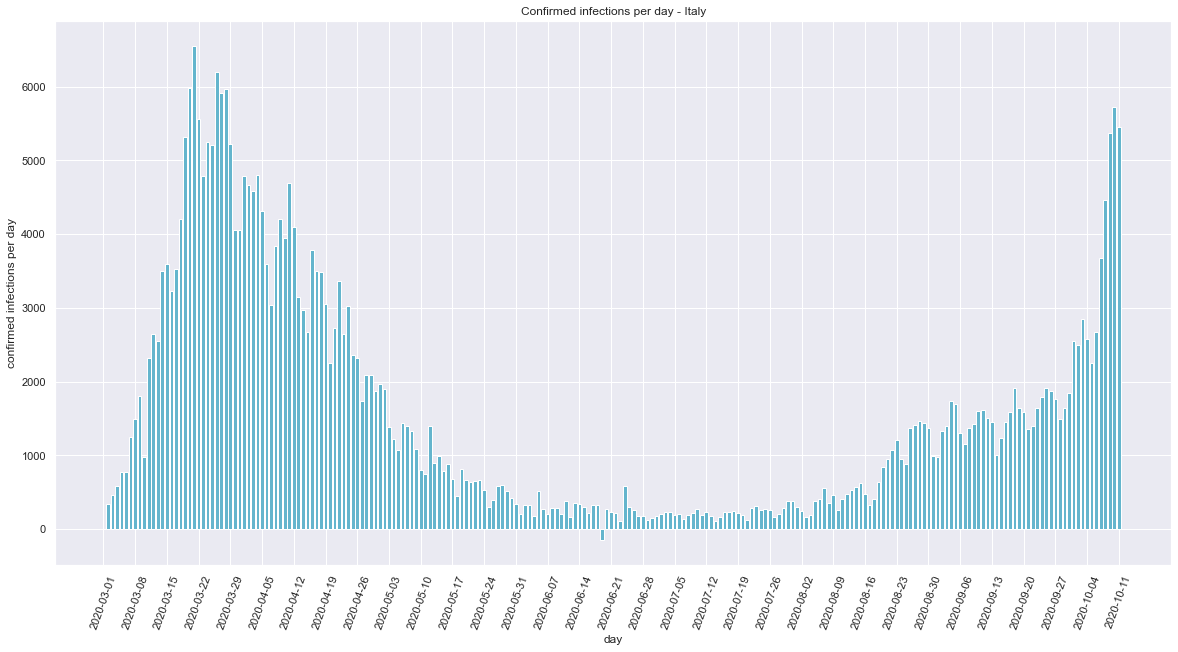

In [46]:
fig = plt.figure(figsize=(20, 10))
ax = fig.add_subplot()
ax.set_title("Confirmed infections per day - Italy")
ax.set_xlabel("day")
ax.set_ylabel("confirmed infections per day");
ax.set_xticks(week_index)
ax.set_xticklabels(week_index, rotation=70)
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
plt.bar(date_index_array[1:], confirmed_per_day_array_it, color='c')

### Cumulative deaths
The number of deaths each day is the sum of the deaths from the beginning up to that day.

In [15]:
deaths_dataset_it = deaths_dataset[deaths_dataset['Country/Region'] == 'Italy']
deaths_dataset_values_it = [death for death in deaths_dataset_it.values[0][start_date_index:]]
deaths_it = pd.Series(deaths_dataset_values_it, index=date_index)
deaths_it['2020-10-01':]

2020-10-01    35918
2020-10-02    35941
2020-10-03    35968
2020-10-04    35986
2020-10-05    36002
2020-10-06    36030
2020-10-07    36061
2020-10-08    36083
2020-10-09    36111
2020-10-10    36140
2020-10-11    36166
Freq: D, dtype: int64

### Deaths per day
The deaths per day are computed from the cumulative deaths by computing the difference between two consecutive days.

In [17]:
deaths_per_day_array_it = [deaths_it[d++1] - deaths_it[d] for d in range(date_index.size - 1)]
deaths_per_day_it = pd.Series(deaths_per_day_array_it, index=date_index[1:])
deaths_per_day_it['2020-10-01':]

2020-10-01    24
2020-10-02    23
2020-10-03    27
2020-10-04    18
2020-10-05    16
2020-10-06    28
2020-10-07    31
2020-10-08    22
2020-10-09    28
2020-10-10    29
2020-10-11    26
Freq: D, dtype: int64

<BarContainer object of 224 artists>

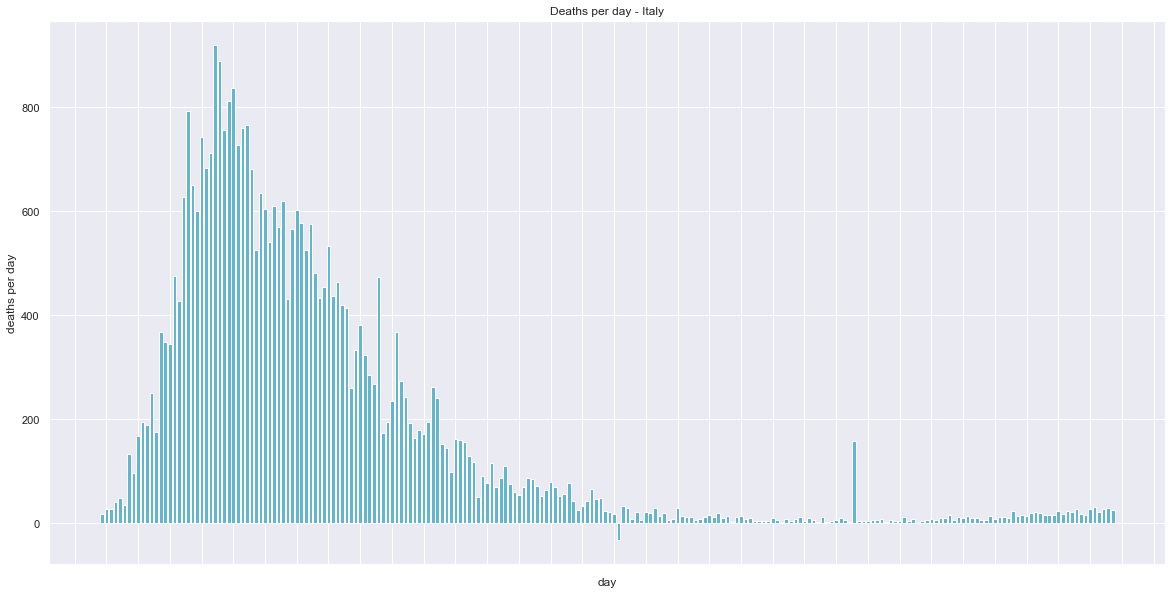

In [18]:
fig = plt.figure(figsize=(20, 10))
ax = fig.add_subplot()
ax.set_title("Deaths per day - Italy")
ax.set_xlabel("day")
ax.set_ylabel("deaths per day");
ax.set_xticks(week_index)
ax.set_xticklabels(week_index, rotation=70)
ax.xaxis.set_major_locator(mdates.WeekdayLocator(interval=1))
plt.bar(date_index_array[1:], deaths_per_day_array_it, color='c')

### Cumulative confirmed infections doubling time
Number of days for the cumulative confirmed infections to double

In [20]:
doubling_time_it = doubling_time(confirmed_infections_it)[end_day]
summary['Doubling Time']['Italy'] = doubling_time(confirmed_infections_it)[end_day]
print("Italy's cumulative infections doubling time = %.0d days"%doubling_time_it)

Italy's cumulative infections doubling time = 176 days


### Cumulative incidence

In [21]:
cumulative_incidence_it = (confirmed_infections_it[confirmed_infections_it.size - 1] / population_it) * 100000
summary['Incidence']['Italy'] = round((confirmed_infections_it[confirmed_infections_it.size - 1] / population_it) * 100000)
print("Italy's cumulative incidence = %.0f per 100.000 persons"%cumulative_incidence_it)

Italy's cumulative incidence = 588 per 100.000 persons


### Case fatality

In [23]:
last_infections_it = confirmed_infections_it[confirmed_infections_it.size - 1]
last_deaths_it = deaths_it[deaths_it.size - 1]
last_case_fatality_it = (last_deaths_it / last_infections_it) * 100
summary['Confirmed Infections']['Italy'] = confirmed_infections_it[confirmed_infections_it.size - 1]
summary['Deaths']['Italy'] = deaths_it[deaths_it.size - 1]
summary['Case Fatality']['Italy'] = round((deaths_it[deaths_it.size - 1] / confirmed_infections_it[confirmed_infections_it.size - 1]) * 100,1)
print("Last report day: {0:4s} \ndeaths: {1:5d}; cumulative confirmed infections: {2:5d}; case fatality {3:5.2f} %".format(end_day, last_deaths_it, last_infections_it, last_case_fatality_it))  

Last report day: 2020-10-11 
deaths: 36166; cumulative confirmed infections: 354950; case fatality 10.19 %


In [43]:
cf_array_it = [(deaths_it[d] / confirmed_infections_it[d]) * 100 for d in range(date_index.size)]
cf_it = pd.Series(cf_array_it, index=date_index)

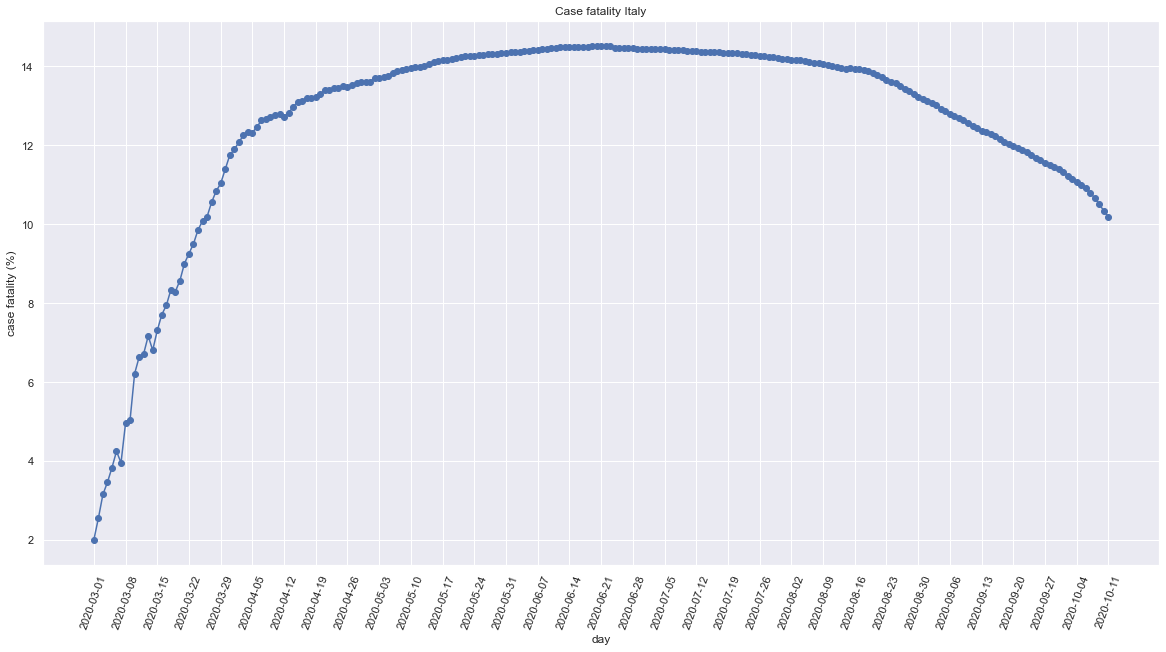

In [47]:
fig = plt.figure(figsize=(20, 10))
ax = fig.add_subplot()
ax.set_title("Case fatality Italy")
ax.set_xlabel("day")
ax.set_ylabel("case fatality (%)");
ax.set_xticks(week_index)
ax.set_xticklabels(week_index, rotation=70)
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
plt.plot(cf_it, marker='o')

***
## Germany

In [48]:
population_de = population[population['country_code'] == 'DE']['total'].values[0]
print("Germany's population (2019) = %d"%population_de)

Germany's population (2019) = 83019213


In [49]:
beds_de = beds[beds['country_code'] == 'DE']['2017'].values[0]
print("Germany's public and private health care facilities, available beds in 2017 = %d"%beds_de)

Germany's public and private health care facilities, available beds in 2017 = 661448


In [50]:
people_per_bed_de =  population_de / beds_de 
print("Number of persons per bed = %.0f"%people_per_bed_de)

Number of persons per bed = 126


### Cumulative confirmed infections
The number of infected individuals each day is the sum of all the confirmed infected individuals from the beginning up to that day.

In [51]:
confirmed_dataset_de = confirmed_dataset[confirmed_dataset['Country/Region'] == 'Germany'] 
confirmed_dataset_values_de = [confirmed for confirmed in confirmed_dataset_de.values[0][start_date_index:]] 
confirmed_infections_de = pd.Series(confirmed_dataset_values_de, index=date_index)
confirmed_infections_de['2020-10-01':] 

2020-10-01    295539
2020-10-02    298374
2020-10-03    300027
2020-10-04    301573
2020-10-05    304673
2020-10-06    307127
2020-10-07    311137
2020-10-08    315941
2020-10-09    320495
2020-10-10    323463
2020-10-11    326309
Freq: D, dtype: int64

### Confirmed infections per day
The confirmed infections per day are computed from the cumulative confirmed infections by computing the difference between two consecutive days.

In [52]:
confirmed_per_day_array_de = [confirmed_infections_de[d++1] - confirmed_infections_de[d] for d in range(date_index.size - 1)]
confirmed_per_day_de = pd.Series(confirmed_per_day_array_de, index=date_index[1:])
confirmed_per_day_de['2020-10-01':]

2020-10-01    2626
2020-10-02    2835
2020-10-03    1653
2020-10-04    1546
2020-10-05    3100
2020-10-06    2454
2020-10-07    4010
2020-10-08    4804
2020-10-09    4554
2020-10-10    2968
2020-10-11    2846
Freq: D, dtype: int64

<BarContainer object of 224 artists>

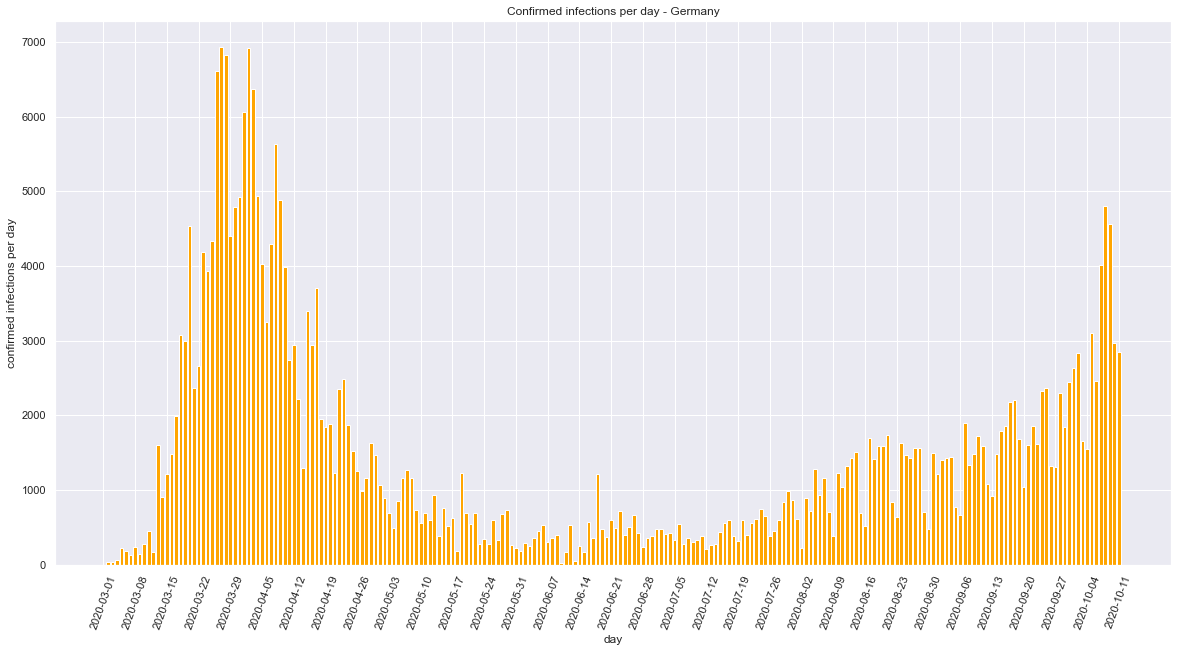

In [55]:
fig = plt.figure(figsize=(20, 10))
ax = fig.add_subplot()
ax.set_title("Confirmed infections per day - Germany")
ax.set_xlabel("day")
ax.set_ylabel("confirmed infections per day");
ax.set_xticks(week_index)
ax.set_xticklabels(week_index, rotation=70)
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
plt.bar(date_index_array[1:], confirmed_per_day_array_de, color='orange')

### Cumulative deaths
The number of deaths each day is the sum of the deaths from the beginning up to that day.

In [56]:
deaths_dataset_de = deaths_dataset[deaths_dataset['Country/Region'] == 'Germany']
deaths_dataset_values_de = [death for death in deaths_dataset_de.values[0][start_date_index:]]
deaths_de = pd.Series(deaths_dataset_values_de, index=date_index)
deaths_de['2020-10-01':]

2020-10-01    9509
2020-10-02    9518
2020-10-03    9531
2020-10-04    9533
2020-10-05    9554
2020-10-06    9566
2020-10-07    9582
2020-10-08    9545
2020-10-09    9599
2020-10-10    9620
2020-10-11    9626
Freq: D, dtype: int64

### Deaths per day
The deaths per day are computed from the cumulative deaths by computing the difference between two consecutive days.

In [57]:
deaths_per_day_array_de = [deaths_de[d++1] - deaths_de[d] for d in range(date_index.size - 1)]
deaths_per_day_de = pd.Series(deaths_per_day_array_de, index=date_index[1:])
deaths_per_day_de['2020-10-01':]

2020-10-01    14
2020-10-02     9
2020-10-03    13
2020-10-04     2
2020-10-05    21
2020-10-06    12
2020-10-07    16
2020-10-08   -37
2020-10-09    54
2020-10-10    21
2020-10-11     6
Freq: D, dtype: int64

<BarContainer object of 224 artists>

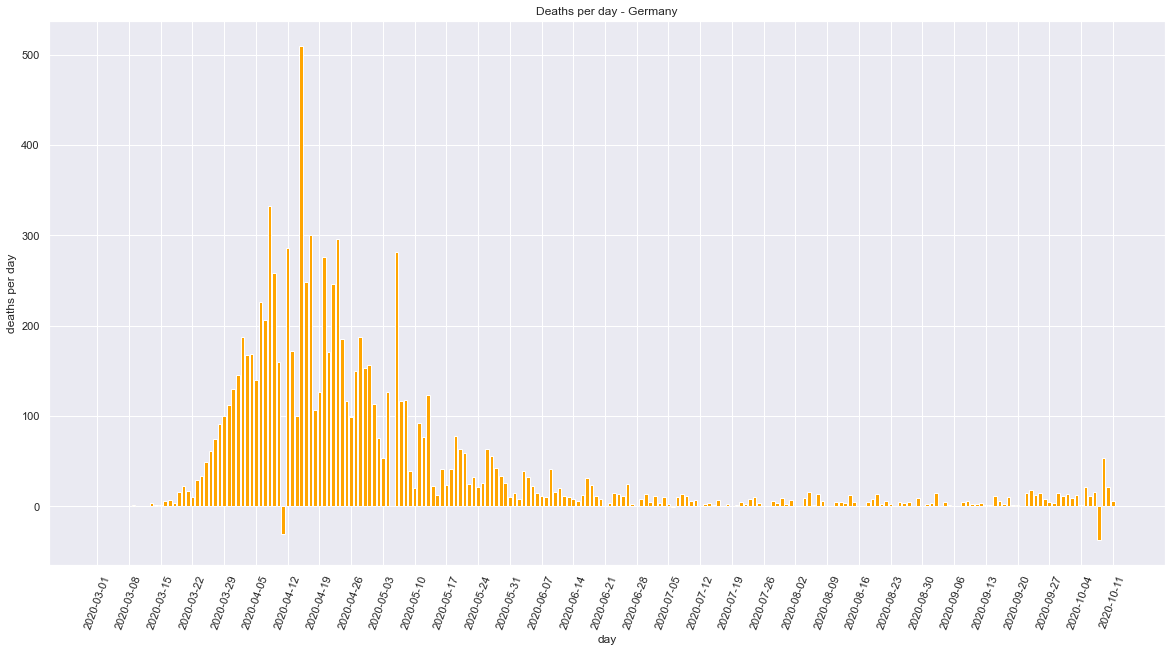

In [58]:
fig = plt.figure(figsize=(20, 10))
ax = fig.add_subplot()
ax.set_title("Deaths per day - Germany")
ax.set_xlabel("day")
ax.set_ylabel("deaths per day");
ax.set_xticks(week_index)
ax.set_xticklabels(week_index, rotation=70)
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
plt.bar(date_index_array[1:], deaths_per_day_array_de, color='orange')

### Cumulative confirmed infections doubling time
Number of days for the cumulative confirmed infections to double

In [59]:
doubling_time_de = doubling_time(confirmed_infections_de)[end_day]
summary['Doubling Time']['Germany'] = doubling_time(confirmed_infections_de)[end_day]
print("Germany's cumulative infections doubling time = %.0d days"%doubling_time_de)

Germany's cumulative infections doubling time = 164 days


### Cumulative incidence

In [60]:
cumulative_incidence_de = (confirmed_infections_de[confirmed_infections_de.size - 1] / population_de) * 100000
summary['Incidence']['Germany'] = round((confirmed_infections_de[confirmed_infections_de.size - 1] / population_de) * 100000)
print("Germany's cumulative incidence = %.0f per 100.000 persons"%cumulative_incidence_de)

Germany's cumulative incidence = 393 per 100.000 persons


### Case fatality

In [61]:
last_infections_de = confirmed_infections_de[confirmed_infections_de.size - 1]
last_deaths_de = deaths_de[deaths_de.size - 1]
last_case_fatality_de = (last_deaths_de / last_infections_de) * 100 
summary['Confirmed Infections']['Germany'] = confirmed_infections_de[confirmed_infections_de.size - 1]
summary['Deaths']['Germany'] = deaths_de[deaths_de.size - 1]
summary['Case Fatality']['Germany'] = round((deaths_de[deaths_de.size - 1] / confirmed_infections_de[confirmed_infections_de.size - 1]) * 100,1)
print("Last report day: {0:4s} \ndeaths: {1:5d}; cumulative confirmed infections: {2:5d}; case fatality {3:5.2f} %".format(end_day, last_deaths_de, last_infections_de, last_case_fatality_de))  

Last report day: 2020-10-11 
deaths:  9626; cumulative confirmed infections: 326309; case fatality  2.95 %


In [63]:
cf_array_de = [(deaths_de[d] / confirmed_infections_de[d]) * 100 for d in range(date_index.size)]
cf_de = pd.Series(cf_array_de, index=date_index)

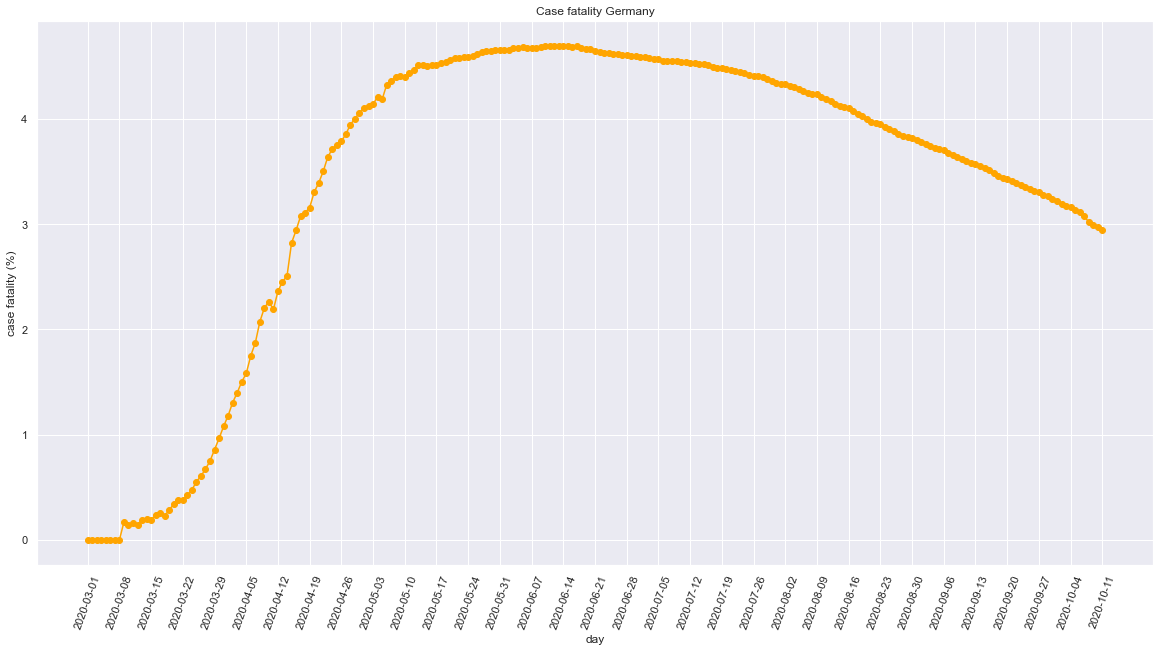

In [64]:
fig = plt.figure(figsize=(20, 10))
ax = fig.add_subplot()
ax.set_title("Case fatality Germany")
ax.set_xlabel("day")
ax.set_ylabel("case fatality (%)");
ax.set_xticks(week_index)
ax.set_xticklabels(week_index, rotation=70)
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
plt.plot(cf_de, color='orange', marker='o')

***
## France

In [65]:
population_fr = population[population['country_code'] == 'FR']['total'].values[0]
print("France's population (2019) = %d"%population_fr)

France's population (2019) = 67012883


In [66]:
beds_fr = beds[beds['country_code'] == 'FR']['2017'].values[0]
print("France's public and private health care facilities, available beds in 2017 = %d"%beds_fr)

France's public and private health care facilities, available beds in 2017 = 399865


In [67]:
people_per_bed_fr =  population_fr / beds_fr 
print("Number of persons per bed = %.0f"%people_per_bed_fr)

Number of persons per bed = 168


### Cumulative confirmed infections
The number of infected individuals each day is the sum of all the confirmed infected individuals from the beginning up to that day.

In [68]:
confirmed_dataset_fr = confirmed_dataset[confirmed_dataset['Country/Region'] == 'France']
row_france = 10
confirmed_dataset_values_fr = [confirmed for confirmed in confirmed_dataset_fr.values[row_france][start_date_index:]] 
confirmed_infections_fr = pd.Series(confirmed_dataset_values_fr, index=date_index)
confirmed_infections_fr['2020-10-01':] 

2020-10-01    589825
2020-10-02    601971
2020-10-03    601971
2020-10-04    601971
2020-10-05    636196
2020-10-06    646531
2020-10-07    664178
2020-10-08    682192
2020-10-09    702148
2020-10-10    702148
2020-10-11    702148
Freq: D, dtype: int64

### Confirmed infections per day
The confirmed infections per day are computed from the cumulative confirmed infections by computing the difference between two consecutive days.

In [69]:
confirmed_per_day_array_fr = [confirmed_infections_fr[d++1] - confirmed_infections_fr[d] for d in range(date_index.size - 1)]
confirmed_per_day_fr = pd.Series(confirmed_per_day_array_fr, index=date_index[1:])
confirmed_per_day_fr['2020-10-01':]

2020-10-01    12918
2020-10-02    12146
2020-10-03        0
2020-10-04        0
2020-10-05    34225
2020-10-06    10335
2020-10-07    17647
2020-10-08    18014
2020-10-09    19956
2020-10-10        0
2020-10-11        0
Freq: D, dtype: int64

<BarContainer object of 224 artists>

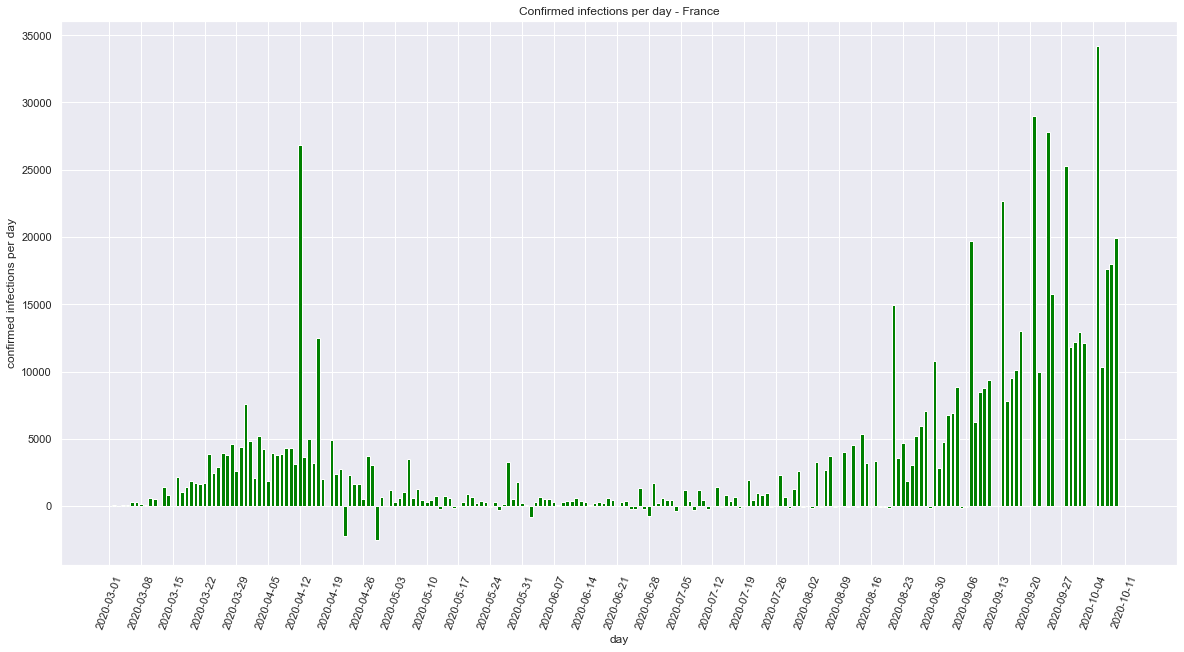

In [73]:
fig = plt.figure(figsize=(20, 10))
ax = fig.add_subplot()
ax.set_title("Confirmed infections per day - France")
ax.set_xlabel("day")
ax.set_ylabel("confirmed infections per day");
ax.set_xticks(week_index)
ax.set_xticklabels(week_index, rotation=70)
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
plt.bar(date_index_array[1:], confirmed_per_day_array_fr, color='green')

### Cumulative deaths
The number of deaths each day is the sum of the deaths from the beginning up to that day.

In [74]:
deaths_dataset_fr = deaths_dataset[deaths_dataset['Country/Region'] == 'France']
deaths_dataset_values_fr = [death for death in deaths_dataset_fr.values[row_france][start_date_index:]]
deaths_fr = pd.Series(deaths_dataset_values_fr, index=date_index)
deaths_fr['2020-10-01':]

2020-10-01    31816
2020-10-02    31952
2020-10-03    31952
2020-10-04    31952
2020-10-05    32096
2020-10-06    32140
2020-10-07    32219
2020-10-08    32295
2020-10-09    32356
2020-10-10    32356
2020-10-11    32356
Freq: D, dtype: int64

### Deaths per day
The deaths per day are computed from the cumulative deaths by computing the difference between two consecutive days.

In [75]:
deaths_per_day_array_fr = [deaths_fr[d++1] - deaths_fr[d] for d in range(date_index.size - 1)]
deaths_per_day_fr = pd.Series(deaths_per_day_array_fr, index=date_index[1:])
deaths_per_day_fr['2020-10-01':]

2020-10-01     47
2020-10-02    136
2020-10-03      0
2020-10-04      0
2020-10-05    144
2020-10-06     44
2020-10-07     79
2020-10-08     76
2020-10-09     61
2020-10-10      0
2020-10-11      0
Freq: D, dtype: int64

<BarContainer object of 224 artists>

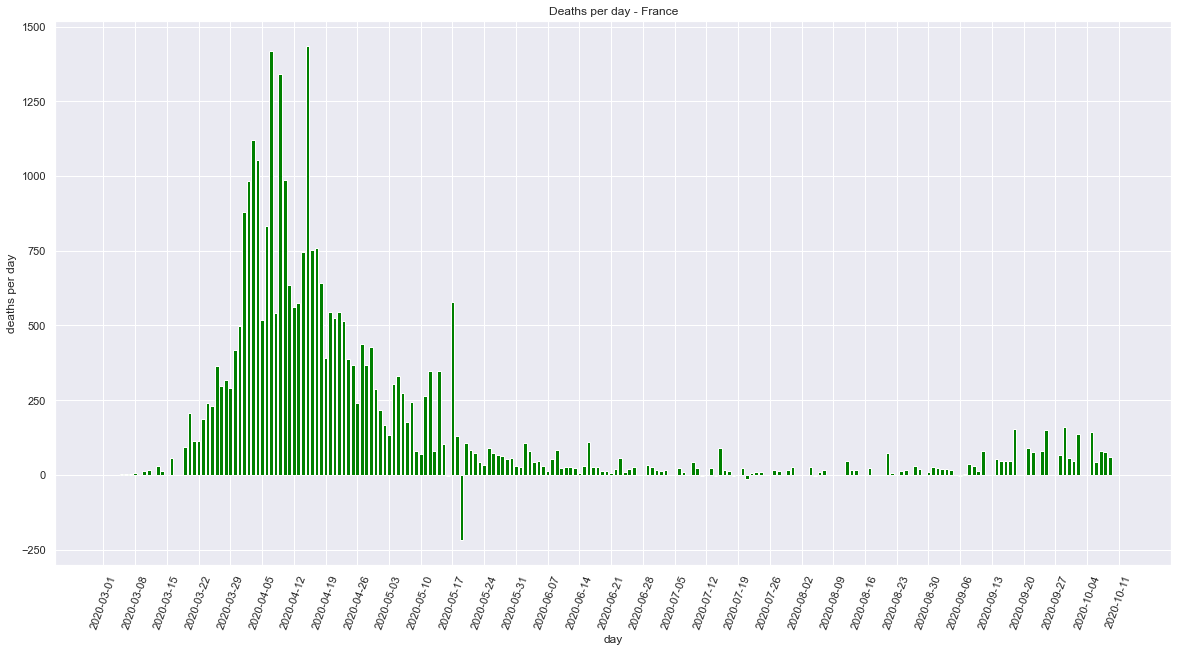

In [76]:
fig = plt.figure(figsize=(20, 10))
ax = fig.add_subplot()
ax.set_title("Deaths per day - France")
ax.set_xlabel("day")
ax.set_ylabel("deaths per day");
ax.set_xticks(week_index)
ax.set_xticklabels(week_index, rotation=70)
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
plt.bar(date_index_array[1:], deaths_per_day_array_fr, color='green')

### Cumulative confirmed infections doubling time
Number of days for the cumulative confirmed infections to double

In [77]:
doubling_time_fr = doubling_time(confirmed_infections_fr)[end_day]
summary['Doubling Time']['France'] = doubling_time(confirmed_infections_fr)[end_day]
print("France's cumulative infections doubling time = %.0d days"%doubling_time_fr)

France's cumulative infections doubling time = 34 days


### Cumulative incidence

In [78]:
cumulative_incidence_fr = (confirmed_infections_fr[confirmed_infections_fr.size - 1] / population_fr) * 100000
summary['Incidence']['France'] = round((confirmed_infections_fr[confirmed_infections_fr.size - 1] / population_fr) * 100000)
print("France's cumulative incidence = %.0f per 100.000 persons"%cumulative_incidence_fr)

France's cumulative incidence = 1048 per 100.000 persons


### Case fatality

In [79]:
last_infections_fr = confirmed_infections_fr[confirmed_infections_fr.size - 1]
last_deaths_fr = deaths_fr[deaths_fr.size - 1]
last_case_fatality_fr = (last_deaths_fr / last_infections_fr) * 100 
summary['Confirmed Infections']['France'] = confirmed_infections_fr[confirmed_infections_fr.size - 1]
summary['Deaths']['France'] = deaths_fr[deaths_fr.size - 1]
summary['Case Fatality']['France'] = round((deaths_fr[deaths_fr.size - 1] / confirmed_infections_fr[confirmed_infections_fr.size - 1]) * 100,1)
print("Last report day: {0:4s} \ndeaths: {1:5d}; cumulative confirmed infections: {2:5d}; case fatality {3:5.2f} %".format(end_day, last_deaths_fr, last_infections_fr, last_case_fatality_fr))  

Last report day: 2020-10-11 
deaths: 32356; cumulative confirmed infections: 702148; case fatality  4.61 %


In [80]:
cf_array_fr = [(deaths_fr[d] / confirmed_infections_fr[d]) * 100 for d in range(date_index.size)]
cf_fr = pd.Series(cf_array_fr, index=date_index)

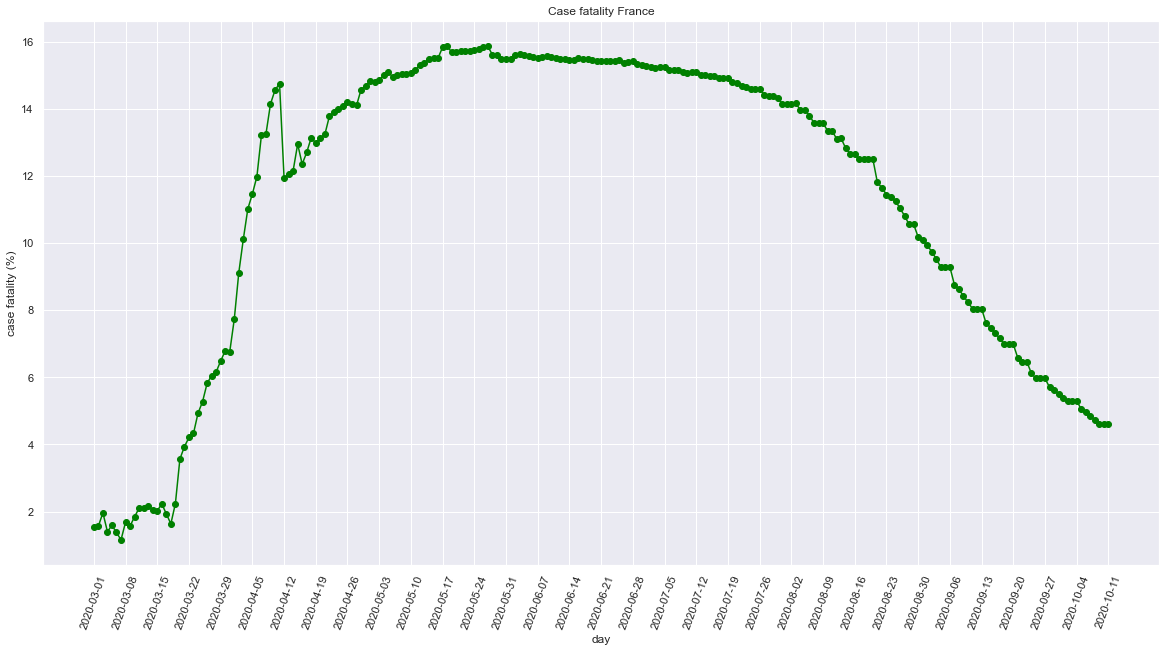

In [81]:
fig = plt.figure(figsize=(20, 10))
ax = fig.add_subplot()
ax.set_title("Case fatality France")
ax.set_xlabel("day")
ax.set_ylabel("case fatality (%)");
ax.set_xticks(week_index)
ax.set_xticklabels(week_index, rotation=70)
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
plt.plot(cf_fr, color='green', marker='o')

***
## Spain

In [82]:
population_es = population[population['country_code'] == 'ES']['total'].values[0]
print("Spain's population (2019) = %d"%population_es)

Spain's population (2019) = 46937060


In [83]:
beds_es = beds[beds['country_code'] == 'ES']['2017'].values[0]
print("Spain's public and private health care facilities, available beds in 2017 = %d"%beds_es)

Spain's public and private health care facilities, available beds in 2017 = 138511


In [84]:
people_per_bed_es =  population_es / beds_es 
print("Number of persons per bed = %.0f"%people_per_bed_es)

Number of persons per bed = 339


### Cumulative confirmed infections
The number of infected individuals each day is the sum of all the confirmed infected individuals from the beginning up to that day.

In [85]:
confirmed_dataset_es = confirmed_dataset[confirmed_dataset['Country/Region'] == 'Spain'] 
confirmed_dataset_values_es = [confirmed for confirmed in confirmed_dataset_es.values[0][start_date_index:]] 
confirmed_infections_es = pd.Series(confirmed_dataset_values_es, index=date_index)
confirmed_infections_es['2020-10-01':] 

2020-10-01    778607
2020-10-02    789932
2020-10-03    789932
2020-10-04    789932
2020-10-05    813412
2020-10-06    825410
2020-10-07    835901
2020-10-08    848324
2020-10-09    861112
2020-10-10    861112
2020-10-11    861112
Freq: D, dtype: int64

### Confirmed infections per day
The confirmed infections per day are computed from the cumulative confirmed infections by computing the difference between two consecutive days.

In [86]:
confirmed_per_day_array_es = [confirmed_infections_es[d++1] - confirmed_infections_es[d] for d in range(date_index.size - 1)]
confirmed_per_day_es = pd.Series(confirmed_per_day_array_es, index=date_index[1:])
confirmed_per_day_es['2020-10-01':]

2020-10-01     9419
2020-10-02    11325
2020-10-03        0
2020-10-04        0
2020-10-05    23480
2020-10-06    11998
2020-10-07    10491
2020-10-08    12423
2020-10-09    12788
2020-10-10        0
2020-10-11        0
Freq: D, dtype: int64

<BarContainer object of 224 artists>

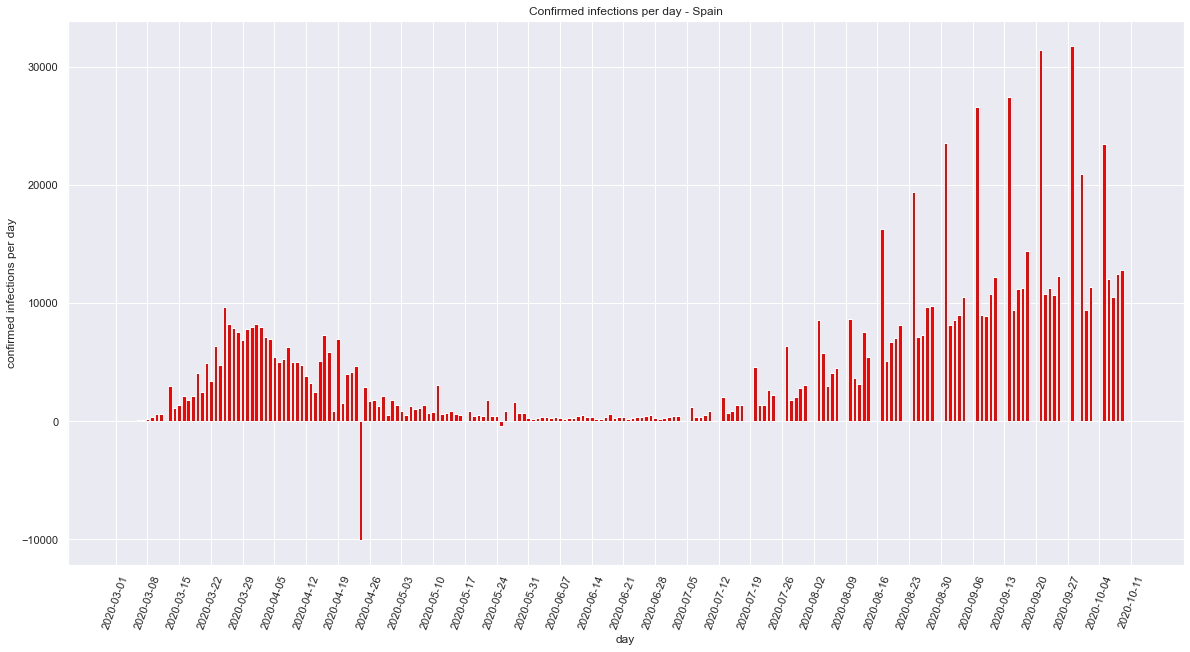

In [88]:
fig = plt.figure(figsize=(20, 10))
ax = fig.add_subplot()
ax.set_title("Confirmed infections per day - Spain")
ax.set_xlabel("day")
ax.set_ylabel("confirmed infections per day");
ax.set_xticks(week_index)
ax.set_xticklabels(week_index, rotation=70)
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
plt.bar(date_index_array[1:], confirmed_per_day_array_es, color='red')

### Cumulative deaths
The number of deaths each day is the sum of the deaths from the beginning up to that day.

In [89]:
deaths_dataset_es = deaths_dataset[deaths_dataset['Country/Region'] == 'Spain']
deaths_dataset_values_es = [death for death in deaths_dataset_es.values[0][start_date_index:]]
deaths_es = pd.Series(deaths_dataset_values_es, index=date_index)
deaths_es['2020-10-01':]

2020-10-01    31973
2020-10-02    32086
2020-10-03    32086
2020-10-04    32086
2020-10-05    32225
2020-10-06    32486
2020-10-07    32562
2020-10-08    32688
2020-10-09    32929
2020-10-10    32929
2020-10-11    32929
Freq: D, dtype: int64

### Deaths per day
The deaths per day are computed from the cumulative deaths by computing the difference between two consecutive days.

In [90]:
deaths_per_day_array_es = [deaths_es[d++1] - deaths_es[d] for d in range(date_index.size - 1)]
deaths_per_day_es = pd.Series(deaths_per_day_array_es, index=date_index[1:])
deaths_per_day_es['2020-10-01':]

2020-10-01    182
2020-10-02    113
2020-10-03      0
2020-10-04      0
2020-10-05    139
2020-10-06    261
2020-10-07     76
2020-10-08    126
2020-10-09    241
2020-10-10      0
2020-10-11      0
Freq: D, dtype: int64

<BarContainer object of 224 artists>

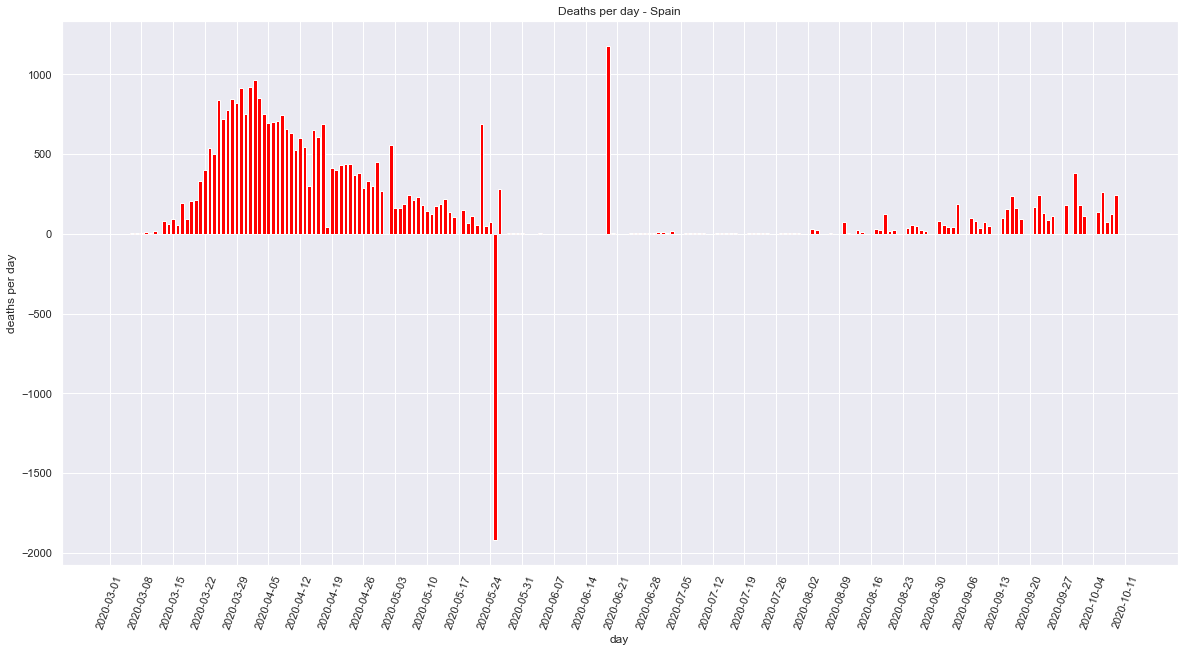

In [91]:
fig = plt.figure(figsize=(20, 10))
ax = fig.add_subplot()
ax.set_title("Deaths per day - Spain")
ax.set_xlabel("day")
ax.set_ylabel("deaths per day");
ax.set_xticks(week_index)
ax.set_xticklabels(week_index, rotation=70)
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
plt.bar(date_index_array[1:], deaths_per_day_array_es, color='red')

### Cumulative confirmed infections doubling time
Number of days for the cumulative confirmed infections to double

In [93]:
doubling_time_es = doubling_time(confirmed_infections_es)[end_day]
summary['Doubling Time']['Spain'] = doubling_time(confirmed_infections_es)[end_day]
print("Spain's cumulative infections doubling time = %.0d days"%doubling_time_es)

Spain's cumulative infections doubling time = 45 days


### Cumulative incidence

In [94]:
cumulative_incidence_es = (confirmed_infections_es[confirmed_infections_es.size - 1] / population_es) * 100000
summary['Incidence']['Spain'] = round((confirmed_infections_es[confirmed_infections_es.size - 1] / population_es) * 100000)
print("Spain's cumulative incidence = %.0f per 100.000 persons"%cumulative_incidence_es)

Spain's cumulative incidence = 1835 per 100.000 persons


### Case fatality

In [95]:
last_infections_es = confirmed_infections_es[confirmed_infections_es.size - 1]
last_deaths_es = deaths_es[deaths_es.size - 1]
last_case_fatality_es = (last_deaths_es / last_infections_es) * 100 
summary['Confirmed Infections']['Spain'] = confirmed_infections_es[confirmed_infections_es.size - 1]
summary['Deaths']['Spain'] = deaths_es[deaths_es.size - 1]
summary['Case Fatality']['Spain'] = round((deaths_es[deaths_es.size - 1] / confirmed_infections_es[confirmed_infections_es.size - 1]) * 100,1)
print("Last report day: {0:4s} \ndeaths: {1:5d}; cumulative confirmed infections: {2:5d}; case fatality {3:5.2f} %".format(end_day, last_deaths_es, last_infections_es, last_case_fatality_es))  

Last report day: 2020-10-11 
deaths: 32929; cumulative confirmed infections: 861112; case fatality  3.82 %


In [96]:
cf_array_es = [(deaths_es[d] / confirmed_infections_es[d]) * 100 for d in range(date_index.size)]
cf_es = pd.Series(cf_array_es, index=date_index)

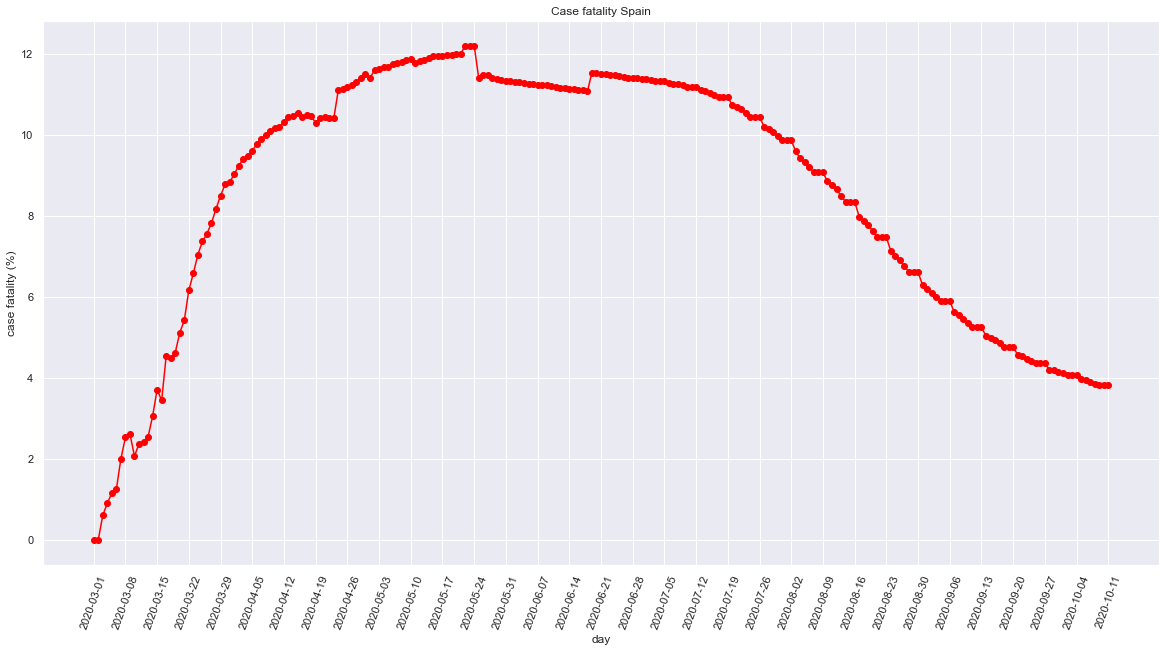

In [97]:
fig = plt.figure(figsize=(20, 10))
ax = fig.add_subplot()
ax.set_title("Case fatality Spain")
ax.set_xlabel("day")
ax.set_ylabel("case fatality (%)");
ax.set_xticks(week_index)
ax.set_xticklabels(week_index, rotation=70)
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
plt.plot(cf_es, color='red', marker='o')

***
## Comparisons
Merged graphs for Italy, Germany, France and Spain

### Cumulative confirmed infections

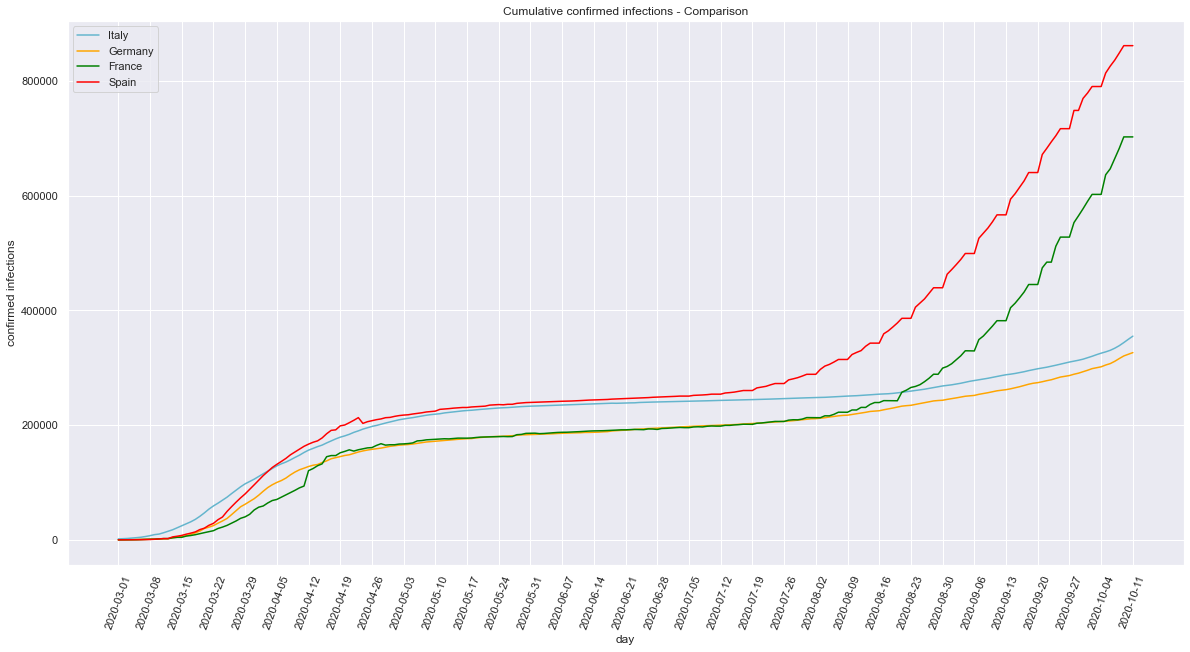

In [100]:
fig = plt.figure(figsize=(20, 10))
ax = fig.add_subplot()
ax.set_title("Cumulative confirmed infections - Comparison")
ax.set_xlabel("day")
ax.set_ylabel("confirmed infections");
ax.set_xticks(week_index)
ax.set_xticklabels(week_index, rotation=70)
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
pi_it, = plt.plot(confirmed_infections_it, label='Italy', color='c')
pi_de, = plt.plot(confirmed_infections_de, label='Germany', color='orange')
pi_fr, = plt.plot(confirmed_infections_fr, label='France', color='green')
pi_es, = plt.plot(confirmed_infections_es, label='Spain', color='red')
plt.legend(handles=[pi_it, pi_de, pi_fr, pi_es])

### Doubling Time
Doubling time for the confirmed infections

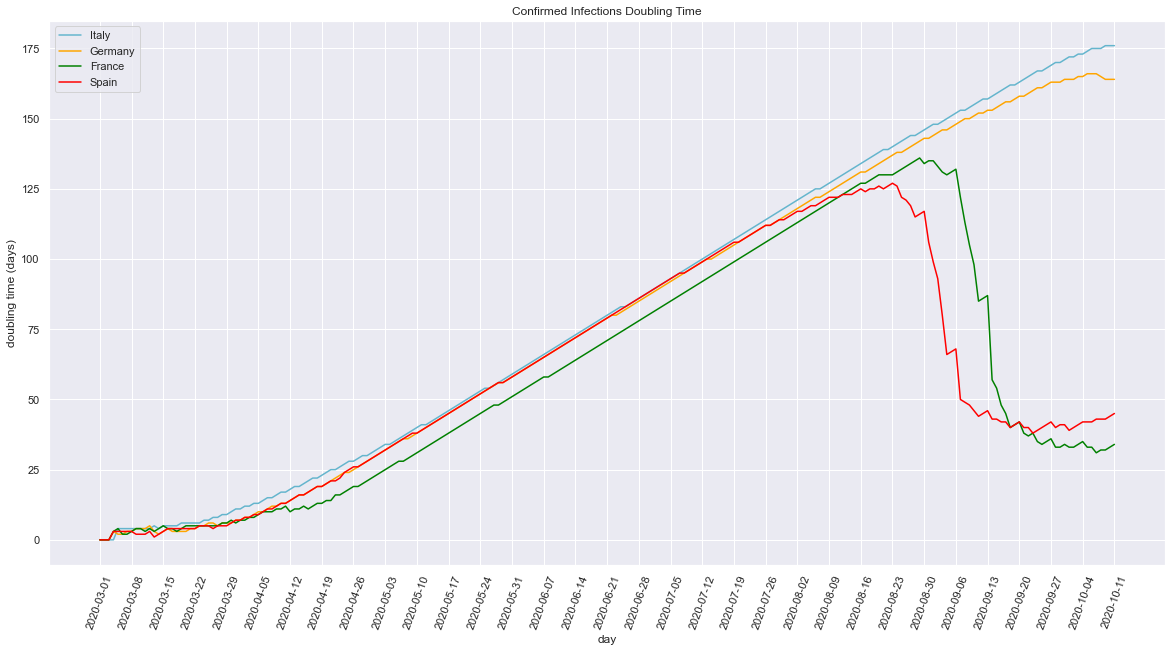

In [101]:
fig = plt.figure(figsize=(20, 10))
ax = fig.add_subplot()
ax.set_title("Confirmed Infections Doubling Time")
ax.set_xlabel("day")
ax.set_ylabel("doubling time (days)");
ax.set_xticks(week_index)
ax.set_xticklabels(week_index, rotation=70)
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
pi_it, = plt.plot(doubling_time(confirmed_infections_it), label='Italy', color='c')
pi_de, = plt.plot(doubling_time(confirmed_infections_de), label='Germany', color='orange')
pi_fr, = plt.plot(doubling_time(confirmed_infections_fr), label='France', color='green')
pi_es, = plt.plot(doubling_time(confirmed_infections_es), label='Spain', color='red')
plt.legend(handles=[pi_it, pi_de, pi_fr, pi_es])
plt.savefig('doubling-time.png')

### Cumulative deaths

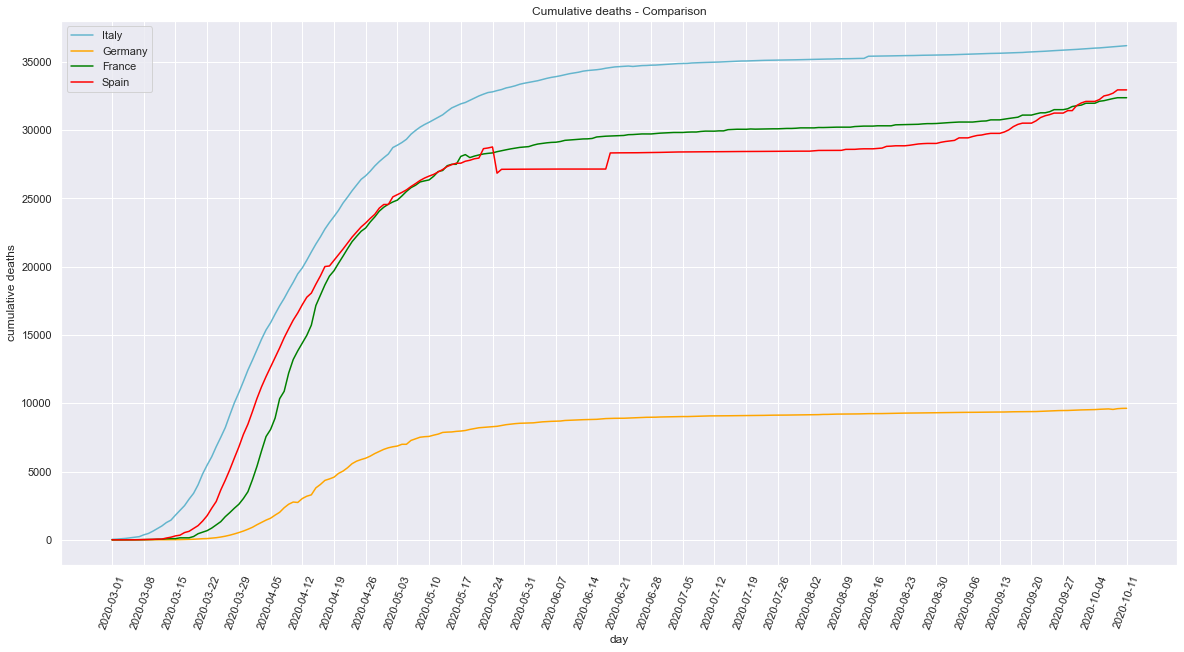

In [102]:
fig = plt.figure(figsize=(20, 10))
ax = fig.add_subplot()
ax.set_title("Cumulative deaths - Comparison")
ax.set_xlabel("day")
ax.set_ylabel("cumulative deaths");
ax.set_xticks(week_index)
ax.set_xticklabels(week_index, rotation=70)
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
pd_it, = plt.plot(deaths_it, label='Italy', color='c')
pd_de, = plt.plot(deaths_de, label='Germany', color='orange')
pd_fr, = plt.plot(deaths_fr, label='France', color='green')
pd_es, = plt.plot(deaths_es, label='Spain', color='red')
plt.legend(handles=[pd_it, pd_de, pd_fr, pd_es])

### Confirmed infections per day

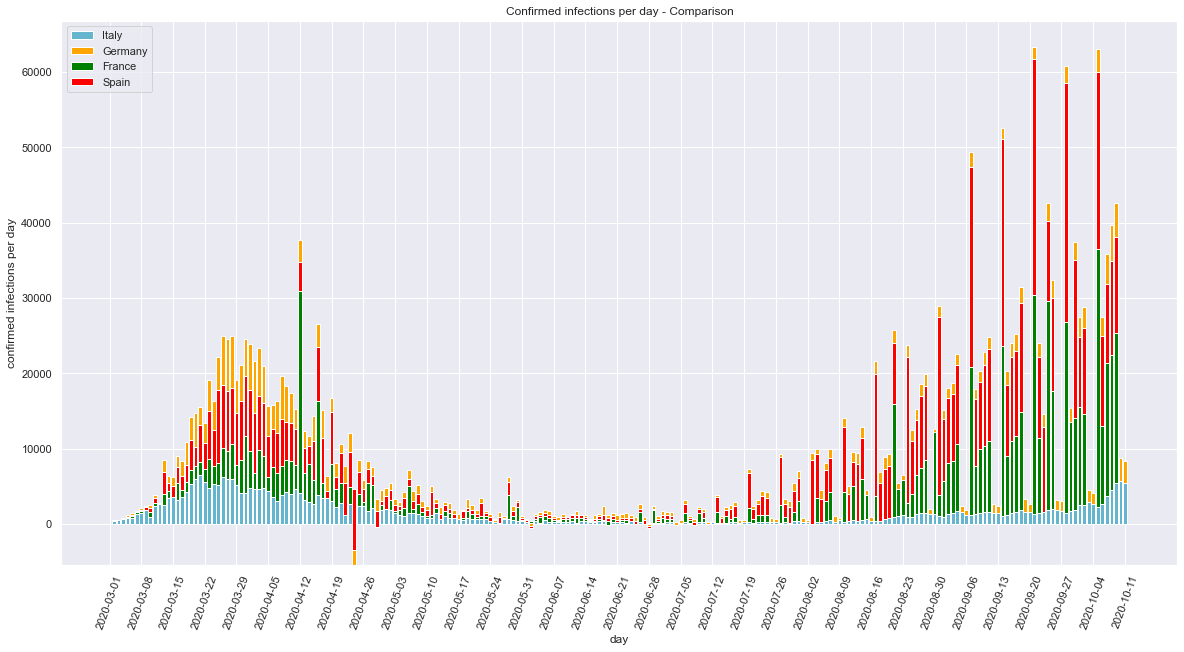

In [104]:
fig = plt.figure(figsize=(20, 10))
ax = fig.add_subplot()
ax.set_title("Confirmed infections per day - Comparison")
ax.set_xlabel("day")
ax.set_ylabel('confirmed infections per day')
ax.set_xticks(week_index)
ax.set_xticklabels(week_index, rotation=70)
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
pi_it = plt.bar(date_index_array[1:], confirmed_per_day_array_it, color='c')
pi_fr = plt.bar(date_index_array[1:], confirmed_per_day_array_fr, bottom=confirmed_per_day_array_it, color='green')
len_array = len(confirmed_per_day_array_it)
bar_base = [confirmed_per_day_array_it[d] + confirmed_per_day_array_fr[d] for d in range(len_array)]
pi_es = plt.bar(date_index_array[1:], confirmed_per_day_array_es, bottom = bar_base, color='red')
bar_base = [bar_base[d] + confirmed_per_day_array_es[d] for d in range(len_array)] # bottom update
pi_de = plt.bar(date_index_array[1:], confirmed_per_day_array_de, bottom = bar_base, color='orange')
plt.legend((pi_it, pi_de, pi_fr, pi_es), ['Italy', 'Germany', 'France', 'Spain'], loc='upper left')
#plt.savefig('deaths-per-day.png')

### Deaths per day

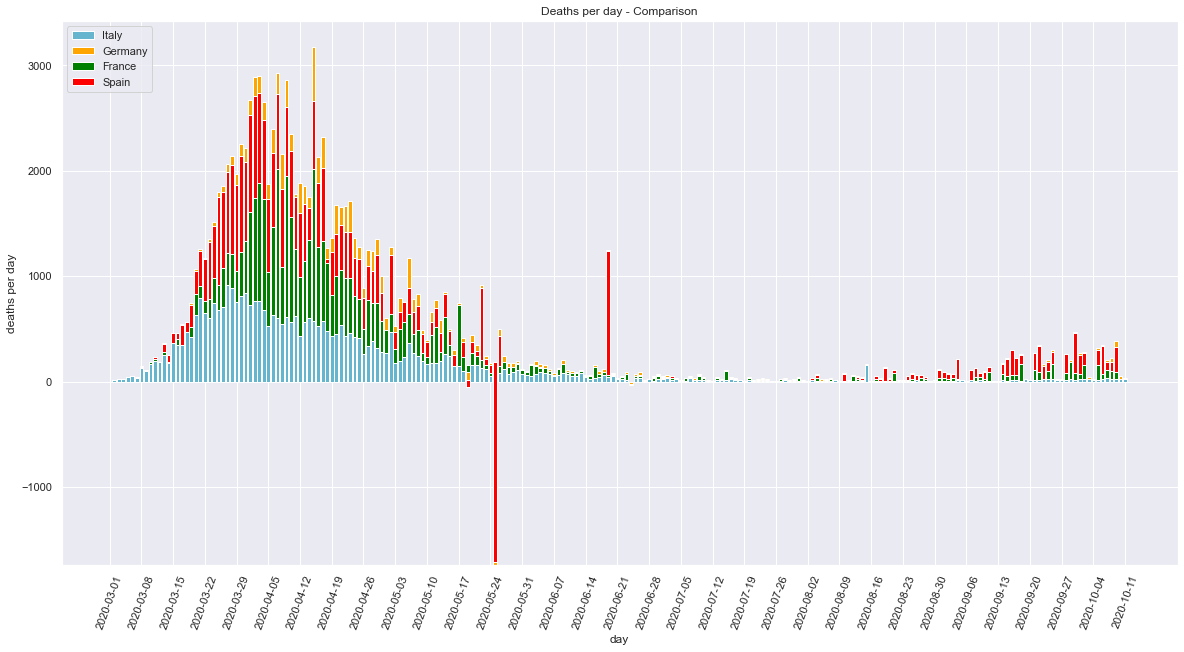

In [105]:
fig = plt.figure(figsize=(20, 10))
ax = fig.add_subplot()
ax.set_title("Deaths per day - Comparison")
ax.set_xlabel("day")
ax.set_ylabel('deaths per day')
ax.set_xticks(week_index)
ax.set_xticklabels(week_index, rotation=70)
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
pi = plt.bar(date_index_array[1:], deaths_per_day_array_it, color='c')
pf = plt.bar(date_index_array[1:], deaths_per_day_array_fr, bottom = deaths_per_day_array_it, color='green')
len_array = len(deaths_per_day_array_it)
bar_base = [deaths_per_day_array_it[d] + deaths_per_day_array_fr[d] for d in range(len_array)]
ps = plt.bar(date_index_array[1:], deaths_per_day_array_es, bottom = bar_base, color='red')
bar_base = [bar_base[d] + deaths_per_day_array_es[d] for d in range(len_array)]
pg = plt.bar(date_index_array[1:], deaths_per_day_array_de, bottom = bar_base, color='orange')
plt.legend((pi[0], pg[0], pf[0], ps[0]), ['Italy', 'Germany', 'France', 'Spain'], loc='upper left')
#plt.savefig('deaths-per-day.png')

### Case fatality

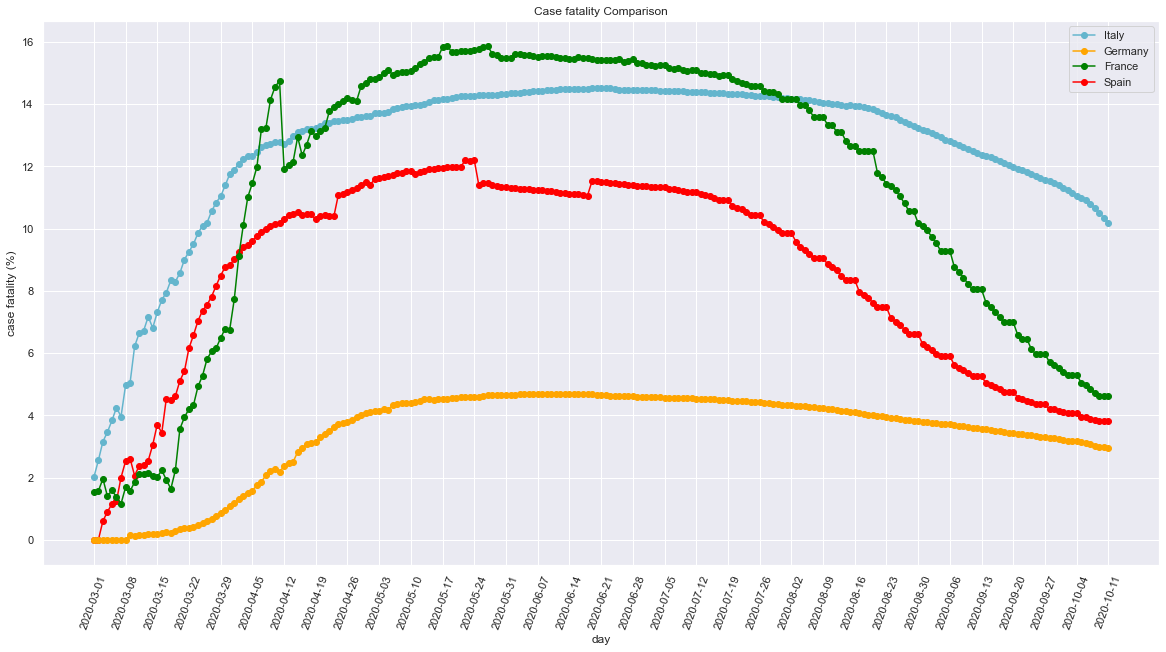

In [106]:
fig = plt.figure(figsize=(20, 10))
ax = fig.add_subplot()
ax.set_title("Case fatality Comparison")
ax.set_xlabel("day")
ax.set_ylabel("case fatality (%)");
ax.set_xticks(week_index)
ax.set_xticklabels(week_index, rotation=70)
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
pcf_it = plt.plot(cf_it, color='c', marker='o')
pcf_es = plt.plot(cf_es, color='red', marker='o')
pcf_fr = plt.plot(cf_fr, color='green', marker='o')
pcf_de = plt.plot(cf_de, color='orange', marker='o')
plt.legend((pcf_it[0], pcf_de[0], pcf_fr[0], pcf_es[0]), ['Italy', 'Germany', 'France', 'Spain'])
#plt.savefig('case_fatalities-2020-03-22.png')

***
## Summary

In [108]:
print("Last report day: ", end_day)  

Last report day:  2020-10-11


In [109]:
summary

,Confirmed Infections,Doubling Time,Incidence,Deaths,Case Fatality
Italy,354950,176,588,36166,10.2
Germany,326309,164,393,9626,2.9
France,702148,34,1048,32356,4.6
Spain,861112,45,1835,32929,3.8


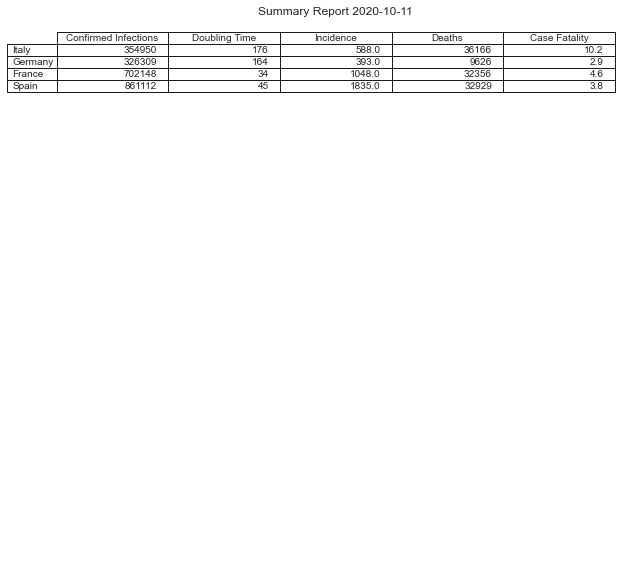

In [110]:
fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(frame_on=False)
ax.axis('off')
ax.table(cellText=summary.values, rowLabels=summary.index, colLabels=summary.columns, loc='upper center')
plt.title('Summary Report ' + end_day)
plt.savefig('summary.png')